# LASER Clustering
## Setup

In [2]:
import argparse
import json
import os
import sys
from collections import defaultdict
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['LASER'] = "../LASER"
sys.path.append("../LASER/source")

import faiss
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import silhouette_score

# LASER imports
from embed import EmbedLoad
from mine_bitexts import knn

In [3]:
LANG = "ko"
USE_GPU = True
NORMALIZE = False

In [4]:
# Read in data
input_dir = f"./data/{LANG}/laser/"
output_dir = f"./results/en_{LANG}"
Path(output_dir).mkdir(exist_ok=True)

en = EmbedLoad(Path(input_dir, f"en_{LANG}_split.train.prompts.npy"))
fo = EmbedLoad(Path(input_dir, f"en_{LANG}_split.train.translations.npy"))
if NORMALIZE:
    faiss.normalize_L2(en) # an inplace operation, used in faiss docs
    faiss.normalize_L2(fo)

In [5]:
# Create the map from prompts to translations
with open(Path(input_dir, "map.json")) as infile:
    sent_map = json.load(infile)

prompt_to_fo_idx = defaultdict(list)
for mapping in sent_map:
    prompt_to_fo_idx[mapping['prompt']].append(mapping['trans'])


In [6]:
with open(Path(input_dir, f"en_{LANG}_split.train.prompts"), "r") as infile:
    en_text = [l.strip() for l in infile]
with open(Path(input_dir, f"en_{LANG}_split.train.translations"), "r") as infile:
    fo_text = [l.strip() for l in infile]

# Baseline results

## Baseline k-means clustering

In [17]:
def train_kmeans(fo, d, k, **kwargs):
    """
    Train kmeans on the translations, with k equal to the number
    of prompts
    """
    kmeans = faiss.Kmeans(d, k, **kwargs)
    kmeans.train(fo)
    # Assigments
    dists, clusters = kmeans.index.search(fo, 1)
    dists, clusters = dists.squeeze(), clusters.squeeze()
    return kmeans, dists, clusters


def calculate_sse_by_k(fo, d, ks, disable_tqdm=False, **kwargs):
    """
    Train multiple kmeans and report the within-cluster SSE for each k
    """
    sse = []
    for k in tqdm(ks, disable=disable_tqdm):
        _, dists, clusters = train_kmeans(fo, d, k, **kwargs)
        sse.append(np.sum(dists))
    return sse

    
def calculate_baseline_sse_by_k(fo, d, ks, b=100, **kwargs):
    """
    Drawing from a uniform distribution, calculate the expected sse
    """
    sse_by_u_by_k = []
    fo_min = fo.min(0)
    fo_max = fo.max(0)
    for _ in tqdm(range(b)):
        u = np.random.uniform(fo_min, fo_max, size=fo.shape).astype(np.float32)
        sse_by_k = calculate_sse_by_k(u, d, ks, disable_tqdm=True, **kwargs)
        sse_by_u_by_k.append(sse_by_k)
    
    return np.array(sse_by_u_by_k)


def sample_sentences_from_top_clusters(clusters, n=5, k=None):
    """
    Sample `n` sentences from the `k` largest clusters
    """
    _, cluster_counts = np.unique(clusters, return_counts=True)
    top_clusters = cluster_counts.argsort()[::-1][:k]
    sent_ids = {}
    for cluster_idx in top_clusters:
        sents_in_cluster = np.where(clusters == cluster_idx)[0]
        sampled = np.random.choice(sents_in_cluster, size=n, replace=False)
        sent_ids[cluster_idx] = sampled
    return sent_ids


def calculate_cluster_quality(clusters, prompt_to_fo_idx):
    """
    Use the assignments to determine purity
    """
    kmeans_results = defaultdict(list)
    for indices in prompt_to_fo_idx.values():
        pred_assigments = clusters[indices].tolist()
        _, counts = np.unique(clusters[indices], return_counts=True)
        kmeans_results['uniq_clusters'].append(len(counts))
        kmeans_results['top_cluster_share'].append(counts[0] / counts.sum())
    return kmeans_results

### Determine optimal k

First, just run for multiple k

In [10]:
k, d = en.shape

In [10]:
ks = [2, 5, 10, 50, 100, 500, 1000, 2500, 5000, 7500, 10000]
ks = sorted(set(ks + [en.shape[0]])) # include the "true" number of clusters

In [15]:
sse_by_k = calculate_sse_by_k(fo, d=d, ks=ks, niter=20, gpu=USE_GPU)

100%|██████████| 12/12 [03:35<00:00, 17.94s/it]


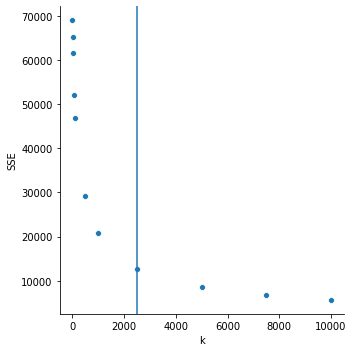

In [12]:
g = sns.relplot(
    x="k",
    y="SSE",
    kind="scatter",
    data=pd.DataFrame({'k': ks, 'SSE': sse_by_k})
)
plt.axvline(en.shape[0],0, max(sse_by_k))

Now, run for random data from uniform distribution to estimate the gap statistic

In [61]:
uniform_baseline_fpath = Path(output_dir, "baseline-uniform-sse.npy")
b = 50
if not uniform_baseline_fpath.exists():
    # takes a very long time to run
    sse_by_k_baseline = calculate_baseline_sse_by_k(fo, d=d, ks=ks, b=b, niter=2, gpu=USE_GPU)
    np.save(uniform_baseline_fpath, sse_by_k_baseline)
else:
    sse_by_k_baseline = np.load(uniform_baseline_fpath)
    assert(len(ks) == sse_by_k_baseline.shape[1])

In [62]:
sse_log_results = pd.DataFrame(
    {
        'k': k,
        'sse': np.log(sse_by_k),
        'sse_unif_mean': np.log(sse_by_k_baseline).mean(0),
        'sse_unif_std': np.log(sse_by_k_baseline).std(0)
    }
)
sse_log_results['gap_stat'] = (
    sse_log_results['sse_unif_mean'] - sse_log_results['sse']
)
sse_log_results['expected_next_gap_stat'] = (
    sse_log_results['gap_stat'] - np.sqrt(1 + 1/b ) * sse_log_results['sse_unif_std']
).shift(-1)

In [63]:
sse_log_results

,k,sse,gap_stat,sse_unif_mean,sse_unif_std,expected_next_gap_stat
0,2,11.141410,5.996005,17.137415,0.000121,6.051835
1,5,11.083669,6.051915,17.135584,0.000079,6.107191
2,10,11.027079,6.107271,17.134350,0.000078,6.271265
3,50,10.860136,6.271372,17.131508,0.000104,6.375039
4,100,10.755061,6.375115,17.130177,0.000075,6.844192
5,500,10.282064,6.844255,17.126320,0.000062,7.177734
6,1000,9.946004,7.177794,17.123798,0.000059,7.667454
7,2500,9.450763,7.667499,17.118261,0.000044,8.059847
8,5000,9.052819,8.059884,17.112703,0.000036,8.284265
9,7500,8.823616,8.284302,17.107918,0.000036,8.456095


In [31]:
plot_gap_data = pd.DataFrame({
    'k': list(sse_log_results.keys())[:-1],
    'Gap (k)': [
        v['gap'] for v in sse_log_results.values()
    ][:-1],
    'Gap(k + 1) - s(k + 1)': [
        v['gap'] - v['sse_unif_std'] for v in sse_log_results.values()
    ][1:]
})


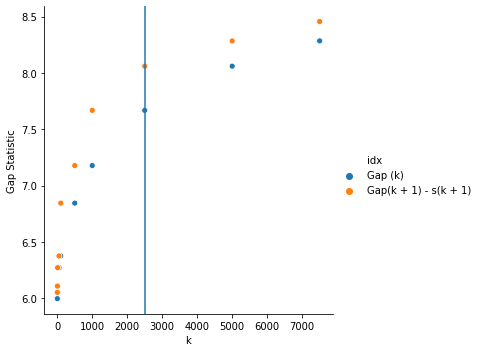

In [33]:
g = sns.relplot(
    x="k",
    y="Gap Statistic",
    hue='idx',
    kind="scatter",
    data=plot_gap_data.melt(
        id_vars='k',
        value_vars=['Gap (k)', 'Gap(k + 1) - s(k + 1)'],
        var_name='idx',
        value_name='Gap Statistic',
    )
)
plt.axvline(en.shape[0], 0, max(sse_by_k))

### Find cluster purity using 2500

In [ ]:
niter = 100
kmeans, _, clusters = train_kmeans(fo, d, k, niter=niter, verbose=True, gpu=USE_GPU)
kmeans_results = calculate_cluster_quality(clusters, prompt_to_fo_idx)

## Baseline prompt-translation similarity

In [11]:
def calc_prompt_to_translation_similarity(en, fo, prompt_to_fo_idx):
    """
    Determine the distances from english prompt representations
    to their translations and find closest neighbors
    """
    sim_results = defaultdict(list) # do prec/rec instead?
    for i, row in tqdm(enumerate(en), total=en.shape[0]):
        true_idx = prompt_to_fo_idx[i]

        true_sim, _ = knn(row[None, :], fo[true_idx], len(true_idx), use_gpu=USE_GPU and len(true_idx)<=1024)
        pred_sim, pred_idx = knn(row[None, :], fo, len(true_idx), use_gpu=USE_GPU and len(true_idx)<=1024)
        
        sim_results['sim_true'].append(true_sim.mean())
        sim_results['sim_pred'].append(pred_sim.mean())

        n_correct = len(set(true_idx) & set(pred_idx.squeeze().tolist()))
        sim_results['accuracy'].append(n_correct / len(true_idx))
    return sim_results

In [13]:
# Determine distances from english to translations
sim_results = calc_prompt_to_translation_similarity(en, fo, prompt_to_fo_idx)

100%|██████████| 2500/2500 [55:21<00:00,  1.33s/it]


In [18]:
sim_results = pd.DataFrame(sim_results)
sim_results['num_translations'] = [len(idx) for idx in prompt_to_fo_idx.values()]
sim_results.to_csv(Path(output_dir, "baseline-similarities.csv"))

In [17]:
sim_results.describe()

,sim_true,sim_pred,accuracy,num_translations
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.825126,0.838420,0.830283,280.164000
std,0.064094,0.052145,0.230783,311.418809
min,0.455998,0.631670,0.000000,17.000000
25%,0.790885,0.805694,0.707555,64.000000
50%,0.836852,0.844293,0.952531,154.000000
75%,0.872535,0.877451,1.000000,380.500000
max,0.956494,0.956494,1.000000,1445.000000


In [59]:
kmeans_results = pd.DataFrame(kmeans_results)
kmeans_results.to_csv(Path(output_dir, "baseline-kmeans.csv"))

In [55]:
kmeans_results.describe()

,uniq_clusters,top_cluster_share
count,2500.000000,2500.000000
mean,2.082800,0.681276
std,1.525279,0.374350
min,1.000000,0.000748
25%,1.000000,0.325881
50%,2.000000,0.990693
75%,3.000000,1.000000
max,14.000000,1.000000


# De-semanticization

## Removal of mean and english representations

In [11]:
fo_demeaned = np.zeros_like(fo)
fo_deprompted = np.zeros_like(fo)

for en_idx, fo_indices in prompt_to_fo_idx.items():
    fo_subset = fo[fo_indices]

    # subtract mean
    fo_demeaned[fo_indices] = fo_subset - fo_subset.mean(0, keepdims=True)
    
    # subtract english representsion
    fo_deprompted[fo_indices] = fo_subset - en[en_idx, None]

## k-means clustering 

### Determine optimal k

In [13]:
ks = [2, 5, 10, 50, 100, 500, 1000, 2500, 5000, 7500, 10000]
ks = sorted(set(ks + [en.shape[0]])) # include the "true" number of clusters

In [14]:
sse_by_k_demeaned = calculate_sse_by_k(fo_demeaned, d=d, ks=ks, niter=20, gpu=USE_GPU)
sse_by_k_deprompted = calculate_sse_by_k(fo_deprompted, d=d, ks=ks, niter=20, gpu=USE_GPU)

100%|██████████| 12/12 [03:29<00:00, 17.44s/it]


In [24]:
sse_comparison_results = pd.DataFrame(
    {
        'k': ks,
        'sse_original': sse_by_k,
        'sse_demeaned': sse_by_k_demeaned,
        'sse_deprompted': sse_by_k_deprompted,
    }
)
sse_comparison_results

,k,sse_original,sse_demeaned,sse_deprompted
0,2,55313.070312,10725.158203,32764.888672
1,5,52232.703125,10452.592773,32066.480469
2,10,49836.617188,10099.351562,31038.123047
3,50,41345.125000,9537.372070,27297.408203
4,100,37121.789062,9095.943359,25283.779297
5,500,21587.248047,7683.078125,17013.730469
6,1000,15085.482422,6857.412109,13048.348633
7,2000,10416.191406,5832.544922,9622.486328
8,2500,9122.513672,5446.821777,8575.170898
9,5000,6114.521484,4349.081543,5971.252441


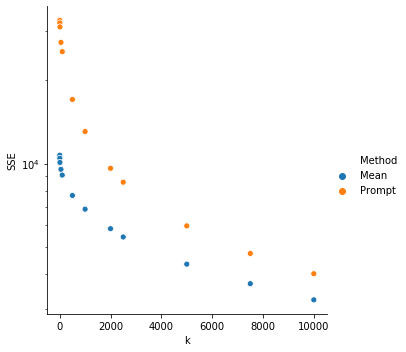

In [22]:
g = sns.relplot(
    x="k",
    y="SSE",
    hue="Method",
    kind="scatter",
    ax=ax,
    data=pd.DataFrame({
        'k': ks + ks,
        'SSE': sse_by_k_demeaned + sse_by_k_deprompted,
        'Method': ['Mean']*len(ks) + ['Prompt']*len(ks)
    })
)
g.set(yscale="log")

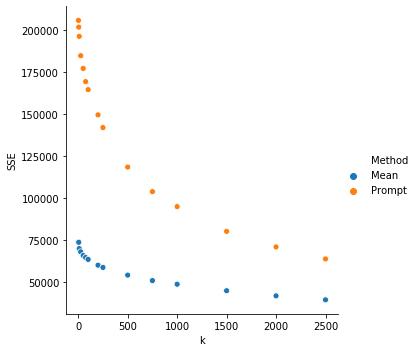

In [81]:
fig, ax = plt.subplots()

# Set the scale of the x-and y-axes
ax.set(yscale="log")

g = sns.relplot(
    x="k",
    y="SSE",
    hue="Method",
    kind="scatter",
    ax=ax,
    data=pd.DataFrame({
        'k': ks + ks,
        'SSE': sse_by_k_demeaned + sse_by_k_deprompted,
        'Method': ['Mean']*len(ks) + ['Prompt']*len(ks)
    })
)

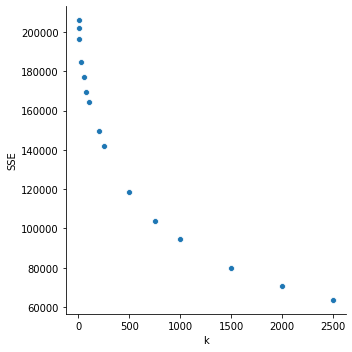

In [102]:
g = sns.relplot(
    x="k",
    y="SSE",
    kind="scatter",
    data=pd.DataFrame({
        'k': ks,
        'SSE': sse_by_k_deprompted,
    })
)

### Clustering

In [12]:
k = 50
niter = 50

In [41]:
kmeans_original, _, clusters_original = train_kmeans(fo, d, k, niter=niter, verbose=True, gpu=USE_GPU, seed=11235)

kmeans_demeaned, _, clusters_demeaned = train_kmeans(fo_demeaned, d, k, niter=niter, verbose=True, gpu=USE_GPU)
kmeans_deprompted, _, clusters_deprompted = train_kmeans(fo_deprompted, d, k, niter=niter, verbose=True, gpu=USE_GPU)

Look at top sentences from each cluster

In [49]:
kmeans_original.centroids.shape

(50, 1024)

In [32]:
clusters = clusters_demeaned

samples = sample_sentences_from_top_clusters(clusters, n=5, k=5)
for cluster_idx, sent_ids in samples.items():
    print(f"\nCluster {cluster_idx:3}")
    for id in sent_ids:
        print(f"{en_text[sent_map[id]['prompt']]:40} | {fo_text[id]}")


Cluster  48
they are not yours.                      | 그것들은 당신 것 아니예요.
i exercise.                              | 전 운동 해요.
you are a modern mother.                 | 너 모던한 어머니이야.
such a thing is possible.                | 이러한 일은 가능해요.
my son eats anywhere.                    | 우리 아들이 어디서고 먹는다.

Cluster  23
we have cheese and apples.               | 우리 치즈하고 사과들을 갖고 있습니다.
goodbye and good night!                  | 안녕히 계세요 그리고 좋은 밤 되세요!
she has an elephant.                     | 그녀한테는 코끼리 한 마리가 있다.
how far is it?                           | 그것은 얼마나 멀리 떨어져 있지?
however, it is possible.                 | 반면, 이것이 가능해.

Cluster  28
i have never seen a volcano.             | 나는 화산을 본 적 없네요.
it is a surprise.                        | 그것은 놀라워.
he wants to respond to her.              | 그는 그녀에게 반응하고 싶어 합니다.
it is cultural.                          | 그것이 문화적인 것 입니다.
she and i will have to sleep at that hotel. | 그녀와 난 저 호텔에서 잠을 자야 할 것이다.

Cluster  32
he likes the pictures.                   | 그가 그 

In [31]:
clusters = clusters_original

samples = sample_sentences_from_top_clusters(clusters, n=5, k=5)
for cluster_idx, sent_ids in samples.items():
    print(f"\nCluster {cluster_idx:3}")
    for id in sent_ids:
        print(f"{en_text[sent_map[id]['prompt']]:40} | {fo_text[id]}")


Cluster  43
the man pays.                            | 남자는 돈을 결제합니다.
they have developed a motor.             | 그녀들은 모터를 하나 개발시켰습니다.
i know the risks.                        | 난 그 위험 요소들을 알고 있어요.
the unit of time is a second.            | 그 시간의 구성 단위가 일초여요.
there are dots in the painting.          | 그림에는 점들이 있어.

Cluster  23
we also eat the root.                    | 우리는 뿌리 또한 먹습니다.
we will cook the fish tomorrow.          | 저희가 내일 그 생선을 요리할 것입니다.
i have to cook my lunch.                 | 난 나의 점심 식사를 만들어야 돼.
i eat with my grandfather.               | 나는 내 할아버지랑 함께 먹는다.
she has prepared lunch.                  | 그녀는 점심 식사를 마련하였어요.

Cluster  49
i read you a book.                       | 난 네게 책을 읽어준다.
a leader reads the newspaper.            | 리더는 신문 읽어.
you open the books.                      | 당신이 그 책을 펼치세요.
we read newspapers.                      | 우리가 여러 신문지을 읽어요.
the man reads the newspaper.             | 사내는 신문 봅니다.

Cluster   2
the universe is very big.                | 우주는 정말 

In [33]:
kmeans_results_demeaned = calculate_cluster_quality(clusters_demeaned, prompt_to_fo_idx)
kmeans_results_deprompted = calculate_cluster_quality(clusters_deprompted, prompt_to_fo_idx)

In [34]:
kmeans_results_demeaned = pd.DataFrame(kmeans_results_demeaned)
kmeans_results_deprompted = pd.DataFrame(kmeans_results_deprompted)

In [35]:
kmeans_results_demeaned.describe()

,uniq_clusters,top_cluster_share
count,2000.000000,2000.000000
mean,6.394000,0.151683
std,2.734685,0.132590
min,2.000000,0.000721
25%,4.000000,0.040000
50%,6.000000,0.125000
75%,8.000000,0.223793
max,17.000000,0.683794


In [36]:
kmeans_results_deprompted.describe()

,uniq_clusters,top_cluster_share
count,2000.00000,2000.000000
mean,2.80500,0.487727
std,1.34234,0.367245
min,1.00000,0.000709
25%,2.00000,0.117228
50%,3.00000,0.493827
75%,4.00000,0.875000
max,9.00000,1.000000


## Similarities following removal of "semantics"

In [ ]:
# TODO: Normalize first?

In [ ]:
# Determine distances from english to translations
sim_results_demeaned = calc_prompt_to_translation_similarity(en, fo_demeaned, prompt_to_fo_idx)

In [ ]:
sim_results_demeaned = pd.DataFrame(sim_results_demeaned)
sim_results_demeaned['num_translations'] = [len(idx) for idx in prompt_to_fo_idx.values()]
sim_results_demeaned.to_csv(Path(output_dir, "demeaned-similarities.csv"))

In [9]:
sim_results_demeaned.describe()

,sim_true,sim_pred,accuracy,num_translations
count,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,-5.655395e-10,0.143129,0.010439,280.164000
std,4.488012e-08,0.031534,0.041717,311.418809
min,-2.213001e-07,0.079581,0.000000,17.000000
25%,-2.281941e-08,0.119397,0.000000,64.000000
50%,3.284897e-10,0.139038,0.000000,154.000000
75%,2.135117e-08,0.162374,0.000000,380.500000
max,3.460702e-07,0.290497,0.445390,1445.000000


In [ ]:
sim_results_deprompted = calc_prompt_to_translation_similarity(en, fo_deprompted, prompt_to_fo_idx)

In [ ]:
sim_results_deprompted = pd.DataFrame(sim_results_deprompted)
sim_results_deprompted['num_translations'] = [len(idx) for idx in prompt_to_fo_idx.values()]
sim_results_deprompted.to_csv(Path(output_dir, "deprompted-similarities.csv"))

In [ ]:
sim_results_deprompted.describe()